# Resnet in torch

implementation of small CIFAR-10 model from He et al 2016

https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

In [3]:
import torch
import torch.nn as nn
import numpy as np
import itertools
from functools import partial
import torch.jit as jit
from contextlib import ExitStack
import matplotlib.pyplot as plt

In [4]:
torch.has_cuda

True

##  load cifar-10

In [5]:
import torchvision
import torchvision.transforms as transforms

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
for X, y in trainloader:
    print(X.min(), X.max())
    print(X.shape)
    print(y.shape)
    break

tensor(-1.) tensor(1.)
torch.Size([256, 3, 32, 32])
torch.Size([256])


## Define model

In [10]:
class ResBlock(nn.Module):
    def __init__(self, module, projection: nn.Module = None):
        super().__init__()
        self.fn = module
        if projection is not None:
            self.projection = projection
        else:
            self.projection = nn.Identity()
    
    def forward(self, X):
        f_x = self.fn(X)
        return self.projection(X) + self.fn(X)

In [11]:
def init_xavier(layer, verbose:bool=False):
    if hasattr(layer, 'weight'):
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(layer.weight)
        else:
            if verbose:
                print('skipping initialization of layer:', layer)
        
def conv_bn_relu(conv_op):
    return nn.Sequential(
        conv_op,
        nn.BatchNorm2d(conv_op.out_channels),#.requires_grad_(False),
        nn.ReLU(inplace=True),
    )

conv3x3 = partial(nn.Conv2d, kernel_size=3, padding='same', bias=False)

class Plain(nn.Module):
    def __init__(self, n):
        super().__init__()
        
        def make_stack(fin, fout, n_middle):
            seq = nn.Sequential(
                conv_bn_relu(conv3x3(fin, fout)),
                *[conv_bn_relu(conv3x3(fout, fout)) for _ in range(n_middle)],
                conv_bn_relu(conv3x3(fout, fout, stride=2, padding=1))
            )
            return seq

        self.conv_ops = nn.Sequential(
            conv_bn_relu(conv3x3(3, 16)),
            make_stack(16, 16, 2 * n - 2),
            make_stack(16, 32, 2 * n - 2),
            make_stack(32, 64, 2 * n - 2),
        )
        self.fc = nn.Linear(64, 10)
    
    def forward(self, X):
        logits = self.fc(self.conv_ops(X).mean((2, 3)))
        return logits

class PlainJit(jit.ScriptModule):
    def __init__(self, n):
        super().__init__()
        
        def make_stack(fin, fout, n_middle):
            seq = nn.Sequential(
                conv_bn_relu(conv3x3(fin, fout)),
                *[conv_bn_relu(conv3x3(fout, fout)) for _ in range(n_middle)],
                conv_bn_relu(conv3x3(fout, fout, stride=2, padding=1))
            )
            return seq

        self.conv_ops = nn.Sequential(
            conv_bn_relu(conv3x3(3, 16)),
            make_stack(16, 16, 2 * n - 2),
            make_stack(16, 32, 2 * n - 2),
            make_stack(32, 64, 2 * n - 2),
        )
        self.fc = nn.Linear(64, 10)

    @jit.script_method
    def forward(self, X):
        logits = self.fc(self.conv_ops(X).mean((2, 3)))
        return logits

In [12]:
plain = Plain(10)
_ = plain.apply(init_xavier)

In [13]:
plainjit = PlainJit(10)
_ = plainjit.apply(init_xavier)

In [14]:
def conv_bn(conv_op):
    return nn.Sequential(
        conv_op,
        nn.BatchNorm2d(conv_op.out_channels).requires_grad_(False),
    )


class Resnet(nn.Module):
    def __init__(self, n):
        super().__init__()
        
        def make_stack(fin, fout, n_middle):
            assert not n_middle & 1, "n_middle must be an even number"
            seq = nn.Sequential(
                conv_bn_relu(conv3x3(fin, fout)),
                *[nn.Sequential(
                    ResBlock(
                        nn.Sequential(
                            conv_bn_relu(conv3x3(fout, fout)),
                            conv_bn(conv3x3(fout, fout)),
                        )
                    ),
                    nn.ReLU(inplace=True),#.requires_grad_(False),
                ) for _ in range(n_middle//2)],
                conv_bn_relu(conv3x3(fout, fout, stride=2, padding=1))
            )
            return seq

        self.conv_ops = nn.Sequential(
            conv_bn_relu(conv3x3(3, 16)),
            make_stack(16, 16, 2 * n - 2),
            make_stack(16, 32, 2 * n - 2),
            make_stack(32, 64, 2 * n - 2),
        )
        self.fc = nn.Linear(64, 10)
    
    def forward(self, X):
        logits = self.fc(self.conv_ops(X).mean((2, 3)))
        return logits


class ResnetJit(jit.ScriptModule):
    def __init__(self, n):
        super().__init__()
        
        def make_stack(fin, fout, n_middle):
            assert not n_middle & 1
            seq = nn.Sequential(
                conv_bn_relu(conv3x3(fin, fout)),
                *[nn.Sequential(
                    ResBlock(
                        nn.Sequential(
                            conv_bn_relu(conv3x3(fout, fout)),
                            conv_bn(conv3x3(fout, fout)),
                        )
                    ),
                    nn.ReLU(inplace=True),#.requires_grad_(False),
                ) for _ in range(n_middle//2)],
                conv_bn_relu(conv3x3(fout, fout, stride=2, padding=1))
            )
            return seq

        self.conv_ops = nn.Sequential(
            conv_bn_relu(conv3x3(3, 16)),
            make_stack(16, 16, 2 * n - 2),
            make_stack(16, 32, 2 * n - 2),
            make_stack(32, 64, 2 * n - 2),
        )
        self.fc = nn.Linear(64, 10)
    
    @jit.script_method
    def forward(self, X):
        logits = self.fc(self.conv_ops(X).mean((2, 3)))
        return logits


###  testing init functions

In [15]:
# testing distance
for batch_num, (X, y) in enumerate(trainloader):
    pdist = nn.PairwiseDistance(p=2)
    pred = plain(X)
    print(pred.shape)
    print(pred)
    d = []
    for p1 in pred:
        for p2 in pred:
            d.append(pdist(p1, p2).item())
    break

torch.Size([256, 10])
tensor([[-0.1566,  0.1438, -0.1416,  ..., -0.1515, -0.0466, -0.3033],
        [-0.2079, -0.0529, -0.2203,  ..., -0.0581, -0.0816, -0.3334],
        [-0.1261,  0.1373, -0.0977,  ..., -0.0538, -0.0153, -0.3994],
        ...,
        [-0.1040,  0.0930, -0.1801,  ..., -0.1046, -0.0397, -0.2665],
        [-0.2006,  0.0915, -0.2718,  ..., -0.1689, -0.0865, -0.3361],
        [-0.4761, -0.4260, -0.8930,  ..., -0.4134, -1.1281, -2.1430]],
       grad_fn=<AddmmBackward0>)


Default: kaiming 
- mean: 0.0038617681631256673
- std: 0.001954058996386977

Xavier:
- mean: 1.3217609798387038
- std: 2.343895194908599

##  Training

In [13]:
def train_epoch(model, data_loader, loss_fn, optimizer, should_profile:bool = False):
    model.train()
    num_examples = len(data_loader.dataset)
    metrics = []
    return_prof = None
    for batch_num, (X, y) in enumerate(data_loader):
        should_profile &= batch_num == 0
        with torch.autograd.profiler.profile(use_cuda=True) if should_profile else ExitStack() as prof:
            X, y = X.to('cuda'), y.to('cuda')
            pred = model(X)
            loss = loss_fn(pred, y)

            pred_max = pred.argmax(1)
            accuracy = (pred.argmax(1) == y).type(torch.float).sum() / pred.shape[0]

            metrics.append({'loss': loss.item(), 'accuracy': accuracy.item()})

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if should_profile:
            return_prof = prof

        if batch_num % 50 == 0:
            print(f'batch: {batch_num: >7d}, {batch_num * batch_size: >7d} / {num_examples}, loss: {loss.item()}, accuracy {accuracy}')
    return metrics, return_prof

In [14]:
def test(model, data_loader, loss_fn):
    model.eval()
    n_examples = len(data_loader.dataset)
    n_batch = len(data_loader)
    
    tot_loss = 0
    n_correct = 0
    for X, y in data_loader:
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        tot_loss += loss_fn(pred, y).item()
        n_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # avg loss, accuracy
    return tot_loss / n_batch, n_correct / n_examples

In [15]:
n = 8  # number of layers is 6n + 1
loss_fn = nn.CrossEntropyLoss()
optimizer = partial(torch.optim.Adam, lr=1e-1)

models = dict()
optimizers = dict()

for n in [2, 8]:
    key = (n, 'p')
    models[key] = Plain(n).apply(init_xavier).to('cuda')
    optimizers[key] = optimizer(models[key].parameters())

    key = (n, 'r')
    models[key] = Resnet(n).apply(init_xavier).to('cuda')
    optimizers[key] = optimizer(models[key].parameters())

In [16]:
def train(model, train_data, test_data, loss_fn, optimizer, n_epochs):
    train_hist = []
    test_hist = []
    for epoch in range(n_epochs):
        print(f'------------------------------------ epoch {epoch}')
        hist, _ = train_epoch(model, train_data, loss_fn, optimizer)
        train_hist.extend(hist)
        test_hist.append(test(model, test_data, loss_fn))
    return train_hist, test_hist

In [17]:
train_histories = dict()
test_histories = dict()
n_epochs = 50

for key in models:
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>', key, '<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
    model = models[key]
    opt = optimizers[key]
    
    train_hist, test_hist = train(model, trainloader, testloader, loss_fn, opt, n_epochs)
    train_histories[key] = train_hist
    test_histories[key] = test_hist

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> (2, 'p') <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
------------------------------------ epoch 0
batch:       0,       0 / 50000, loss: 2.45452880859375, accuracy 0.08984375
batch:      50,   12800 / 50000, loss: 2.064197301864624, accuracy 0.23046875
batch:     100,   25600 / 50000, loss: 1.9794565439224243, accuracy 0.265625
batch:     150,   38400 / 50000, loss: 1.822261929512024, accuracy 0.3203125
------------------------------------ epoch 1
batch:       0,       0 / 50000, loss: 1.7649435997009277, accuracy 0.296875
batch:      50,   12800 / 50000, loss: 1.6806671619415283, accuracy 0.35546875
batch:     100,   25600 / 50000, loss: 1.5546467304229736, accuracy 0.42578125
batch:     150,   38400 / 50000, loss: 1.4842660427093506, accuracy 0.42578125
------------------------------------ epoch 2
batch:       0,       0 / 50000, loss: 1.5184143781661987, accuracy 0.3984375
batch:      50,   12800 / 50000, loss: 1.32500422000885, accuracy 0.44921875
bat

batch:     150,   38400 / 50000, loss: 0.34442102909088135, accuracy 0.87109375
------------------------------------ epoch 23
batch:       0,       0 / 50000, loss: 0.27711910009384155, accuracy 0.91796875
batch:      50,   12800 / 50000, loss: 0.34878697991371155, accuracy 0.859375
batch:     100,   25600 / 50000, loss: 0.3494334816932678, accuracy 0.8828125
batch:     150,   38400 / 50000, loss: 0.3154110908508301, accuracy 0.90625
------------------------------------ epoch 24
batch:       0,       0 / 50000, loss: 0.24973106384277344, accuracy 0.91015625
batch:      50,   12800 / 50000, loss: 0.2660272419452667, accuracy 0.90234375
batch:     100,   25600 / 50000, loss: 0.32584935426712036, accuracy 0.87109375
batch:     150,   38400 / 50000, loss: 0.43788617849349976, accuracy 0.83984375
------------------------------------ epoch 25
batch:       0,       0 / 50000, loss: 0.31441739201545715, accuracy 0.88671875
batch:      50,   12800 / 50000, loss: 0.3127661347389221, accuracy 0.8

batch:     100,   25600 / 50000, loss: 0.14580780267715454, accuracy 0.9453125
batch:     150,   38400 / 50000, loss: 0.19172526895999908, accuracy 0.93359375
------------------------------------ epoch 46
batch:       0,       0 / 50000, loss: 0.16088929772377014, accuracy 0.93359375
batch:      50,   12800 / 50000, loss: 0.09878979623317719, accuracy 0.9609375
batch:     100,   25600 / 50000, loss: 0.12026339024305344, accuracy 0.9609375
batch:     150,   38400 / 50000, loss: 0.17329613864421844, accuracy 0.9296875
------------------------------------ epoch 47
batch:       0,       0 / 50000, loss: 0.13631409406661987, accuracy 0.95703125
batch:      50,   12800 / 50000, loss: 0.09896056354045868, accuracy 0.96484375
batch:     100,   25600 / 50000, loss: 0.12385176122188568, accuracy 0.9453125
batch:     150,   38400 / 50000, loss: 0.13519878685474396, accuracy 0.95703125
------------------------------------ epoch 48
batch:       0,       0 / 50000, loss: 0.13219237327575684, accurac

batch:      50,   12800 / 50000, loss: 0.36866313219070435, accuracy 0.85546875
batch:     100,   25600 / 50000, loss: 0.4736981689929962, accuracy 0.8203125
batch:     150,   38400 / 50000, loss: 0.4449778199195862, accuracy 0.83984375
------------------------------------ epoch 19
batch:       0,       0 / 50000, loss: 0.4158203601837158, accuracy 0.859375
batch:      50,   12800 / 50000, loss: 0.37771326303482056, accuracy 0.8671875
batch:     100,   25600 / 50000, loss: 0.4313163757324219, accuracy 0.82421875
batch:     150,   38400 / 50000, loss: 0.4616616368293762, accuracy 0.8359375
------------------------------------ epoch 20
batch:       0,       0 / 50000, loss: 0.3529195189476013, accuracy 0.86328125
batch:      50,   12800 / 50000, loss: 0.29279953241348267, accuracy 0.89453125
batch:     100,   25600 / 50000, loss: 0.39812853932380676, accuracy 0.8828125
batch:     150,   38400 / 50000, loss: 0.4285283386707306, accuracy 0.83203125
------------------------------------ epoc

batch:       0,       0 / 50000, loss: 0.18950624763965607, accuracy 0.93359375
batch:      50,   12800 / 50000, loss: 0.1270129382610321, accuracy 0.9453125
batch:     100,   25600 / 50000, loss: 0.12255634367465973, accuracy 0.94921875
batch:     150,   38400 / 50000, loss: 0.18710140883922577, accuracy 0.9375
------------------------------------ epoch 42
batch:       0,       0 / 50000, loss: 0.10675988346338272, accuracy 0.95703125
batch:      50,   12800 / 50000, loss: 0.08641604334115982, accuracy 0.9765625
batch:     100,   25600 / 50000, loss: 0.19704127311706543, accuracy 0.921875
batch:     150,   38400 / 50000, loss: 0.20711638033390045, accuracy 0.9296875
------------------------------------ epoch 43
batch:       0,       0 / 50000, loss: 0.08342105150222778, accuracy 0.96875
batch:      50,   12800 / 50000, loss: 0.11447925865650177, accuracy 0.953125
batch:     100,   25600 / 50000, loss: 0.13748474419116974, accuracy 0.953125
batch:     150,   38400 / 50000, loss: 0.2083

------------------------------------ epoch 14
batch:       0,       0 / 50000, loss: 1.1415152549743652, accuracy 0.578125
batch:      50,   12800 / 50000, loss: 1.213966965675354, accuracy 0.546875
batch:     100,   25600 / 50000, loss: 1.229210615158081, accuracy 0.5390625
batch:     150,   38400 / 50000, loss: 1.195788860321045, accuracy 0.55078125
------------------------------------ epoch 15
batch:       0,       0 / 50000, loss: 1.0560957193374634, accuracy 0.64453125
batch:      50,   12800 / 50000, loss: 1.317307949066162, accuracy 0.53515625
batch:     100,   25600 / 50000, loss: 1.2097201347351074, accuracy 0.59375
batch:     150,   38400 / 50000, loss: 1.1020991802215576, accuracy 0.6171875
------------------------------------ epoch 16
batch:       0,       0 / 50000, loss: 1.2021353244781494, accuracy 0.57421875
batch:      50,   12800 / 50000, loss: 1.1025245189666748, accuracy 0.59375
batch:     100,   25600 / 50000, loss: 1.1425880193710327, accuracy 0.5546875
batch:    

------------------------------------ epoch 37
batch:       0,       0 / 50000, loss: 0.6854689121246338, accuracy 0.796875
batch:      50,   12800 / 50000, loss: 0.6585119366645813, accuracy 0.75
batch:     100,   25600 / 50000, loss: 0.8119089603424072, accuracy 0.734375
batch:     150,   38400 / 50000, loss: 0.75653076171875, accuracy 0.75390625
------------------------------------ epoch 38
batch:       0,       0 / 50000, loss: 0.7198362946510315, accuracy 0.75
batch:      50,   12800 / 50000, loss: 0.7475611567497253, accuracy 0.7109375
batch:     100,   25600 / 50000, loss: 0.7214668393135071, accuracy 0.734375
batch:     150,   38400 / 50000, loss: 0.6452165842056274, accuracy 0.78515625
------------------------------------ epoch 39
batch:       0,       0 / 50000, loss: 0.724098265171051, accuracy 0.7265625
batch:      50,   12800 / 50000, loss: 0.6695226430892944, accuracy 0.77734375
batch:     100,   25600 / 50000, loss: 0.6742101311683655, accuracy 0.76953125
batch:     150, 

batch:     150,   38400 / 50000, loss: 0.5580636858940125, accuracy 0.8203125
------------------------------------ epoch 10
batch:       0,       0 / 50000, loss: 0.38041555881500244, accuracy 0.8828125
batch:      50,   12800 / 50000, loss: 0.4615514576435089, accuracy 0.8359375
batch:     100,   25600 / 50000, loss: 0.3573668599128723, accuracy 0.85546875
batch:     150,   38400 / 50000, loss: 0.4575730860233307, accuracy 0.8515625
------------------------------------ epoch 11
batch:       0,       0 / 50000, loss: 0.3999648988246918, accuracy 0.8359375
batch:      50,   12800 / 50000, loss: 0.5416922569274902, accuracy 0.8046875
batch:     100,   25600 / 50000, loss: 0.38780635595321655, accuracy 0.859375
batch:     150,   38400 / 50000, loss: 0.49190497398376465, accuracy 0.8359375
------------------------------------ epoch 12
batch:       0,       0 / 50000, loss: 0.4192224144935608, accuracy 0.84375
batch:      50,   12800 / 50000, loss: 0.3574538230895996, accuracy 0.87109375
ba

batch:     100,   25600 / 50000, loss: 0.07299602031707764, accuracy 0.97265625
batch:     150,   38400 / 50000, loss: 0.10311447829008102, accuracy 0.96484375
------------------------------------ epoch 33
batch:       0,       0 / 50000, loss: 0.11698315292596817, accuracy 0.96484375
batch:      50,   12800 / 50000, loss: 0.03984381631016731, accuracy 0.98828125
batch:     100,   25600 / 50000, loss: 0.09909895807504654, accuracy 0.97265625
batch:     150,   38400 / 50000, loss: 0.08570728451013565, accuracy 0.97265625
------------------------------------ epoch 34
batch:       0,       0 / 50000, loss: 0.11703621596097946, accuracy 0.96875
batch:      50,   12800 / 50000, loss: 0.03711786866188049, accuracy 0.98828125
batch:     100,   25600 / 50000, loss: 0.0392816998064518, accuracy 0.98046875
batch:     150,   38400 / 50000, loss: 0.06970816850662231, accuracy 0.98046875
------------------------------------ epoch 35
batch:       0,       0 / 50000, loss: 0.05822165682911873, accura

In [18]:
train_histories.keys()

dict_keys([(2, 'p'), (2, 'r'), (8, 'p'), (8, 'r')])

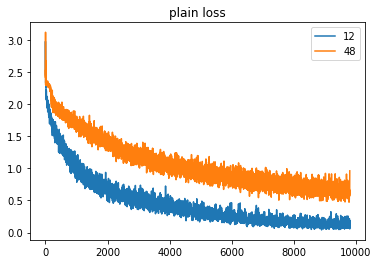

In [27]:
plt.plot([h['loss'] for h in train_histories[(2, 'p')]])
plt.plot([h['loss'] for h in train_histories[(8, 'p')]])
plt.title('plain loss')
plt.legend(['12', '48'])

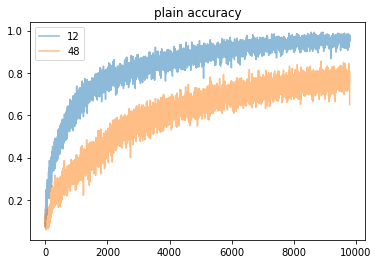

In [34]:
plt.plot([h['accuracy'] for h in train_histories[(2, 'p')]], alpha=.5)
plt.plot([h['accuracy'] for h in train_histories[(8, 'p')]], alpha=.5)
plt.title('plain accuracy')
plt.legend(['12', '48'])

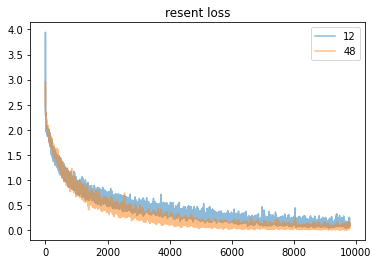

In [33]:
plt.plot([h['loss'] for h in train_histories[(2, 'r')]], alpha=.5)
plt.plot([h['loss'] for h in train_histories[(8, 'r')]], alpha=.5)
plt.title('resent loss')
plt.legend(['12', '48'])

(0.0, 0.4)

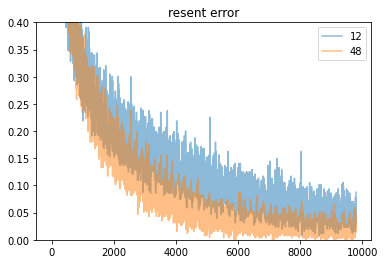

In [41]:
plt.plot([1- h['accuracy'] for h in train_histories[(2, 'r')]], alpha=.5)
plt.plot([1- h['accuracy'] for h in train_histories[(8, 'r')]], alpha=.5)
plt.title('resent error')
plt.legend(['12', '48'])
plt.ylim(0, .4)

(0.0, 0.4)

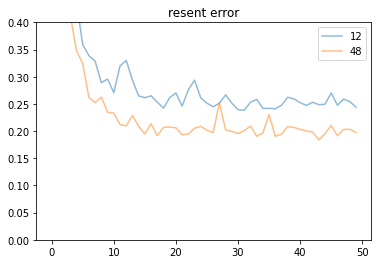

In [42]:
plt.plot([1- h[1] for h in test_histories[(2, 'r')]], alpha=.5)
plt.plot([1- h[1] for h in test_histories[(8, 'r')]], alpha=.5)
plt.title('resent error')
plt.legend(['12', '48'])
plt.ylim(0, .4)

##  Testing out JIT
doesn't seem to make much of a difference in this case

In [386]:
plainjit = PlainJit(n)
_ = plainjit.apply(init_xavier)

resnetjit = ResnetJit(n)
_ = resnetjit.apply(init_xavier)

plain_optimizer_jit = optimizer(plainjit.parameters())
res_optimizer_jit = optimizer(resnetjit.parameters())
plain_gpu_jit = plainjit.to('cuda')
resnet_gpu_jit = resnetjit.to('cuda')

In [364]:
%%time
## removes hanging issue
#with torch.profiler.profile() as profiler:
#    pass
for epoch in range(1):
    print(f'------------------------------------ epoch {epoch}')
    plain_history, _ = train_epoch(plain_gpu, trainloader, plain_optimizer, should_profile=False)

------------------------------------ epoch 0
batch:       0,       0 / 50000, loss: 1.540643572807312, accuracy 0.38671875
batch:      50,   12800 / 50000, loss: 1.5133154392242432, accuracy 0.40625
batch:     100,   25600 / 50000, loss: 1.5546514987945557, accuracy 0.40625
batch:     150,   38400 / 50000, loss: 1.545112133026123, accuracy 0.43359375
CPU times: user 20.6 s, sys: 8.29 s, total: 28.9 s
Wall time: 29.9 s


In [365]:
%%time
for epoch in range(1):
    print(f'------------------------------------ epoch {epoch}')
    plain_jit_history, _ = train_epoch(plain_gpu_jit, trainloader, plain_optimizer_jit, should_profile=False)

------------------------------------ epoch 0
batch:       0,       0 / 50000, loss: 1.8953824043273926, accuracy 0.28515625
batch:      50,   12800 / 50000, loss: 1.9096570014953613, accuracy 0.25
batch:     100,   25600 / 50000, loss: 1.7781020402908325, accuracy 0.34765625
batch:     150,   38400 / 50000, loss: 1.8191620111465454, accuracy 0.3203125
CPU times: user 20.3 s, sys: 8.06 s, total: 28.3 s
Wall time: 29.6 s


In [357]:
# with jit
print(prof.key_averages().table(
    sort_by="self_cuda_time_total", row_limit=1))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                               Optimizer.step#Adam.step         5.15%      38.794ms        52.71%     397.268ms     397.268ms     128.176ms        17.61%     373.844ms     373.844ms             1  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU 

In [354]:
# no jit
print(prof.key_averages().table(
    sort_by="self_cuda_time_total", row_limit=-1))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                               Optimizer.step#Adam.step         5.36%      33.401ms        39.66%     247.195ms     247.195ms     103.450ms        17.69%     222.981ms     222.981ms             1  
                aten::cudnn_convolution_backward_weight         1.20%       7.474ms         4.39%      27.342ms     448.230us      54.155ms         9.26%      56.144ms     920.393us            61  
         